In [1]:
from sys import stdout
from os.path import join, isdir, isfile, exists
import pandas as pd
import numpy as np
from sklearn.mixture import GaussianMixture
import scipy.integrate as integrate
from random import sample
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import time
from scipy import stats

In [2]:
washing_machines = pd.read_hdf('./hes_washing_machines.h5')
dish_washers = pd.read_hdf('./hes_dish_washers.h5')
tumble_dryers = pd.read_hdf('./hes_tumble_dryers.h5')
immersion_heaters = pd.read_hdf('./hes_immersion_heaters.h5')
water_heaters = pd.read_hdf('./hes_water_heaters.h5')
heaters = pd.read_hdf('./hes_heaters.h5')
washing_drying = pd.read_hdf('./hes_washing_drying_machines.h5')

In [3]:
# ADD TO LIB
def getMinMaxDates(df):
    # find the dates that exist for all measurements
    maxdate = df.index.get_level_values('Unix').max()
    mindate = df.index.get_level_values('Unix').min()
    # for all buildings get the common denominator for min and max dates
    for i in np.unique(df.index.get_level_values('building')):
        mask = df.index.get_level_values('building') == i
        if (df.loc[mask].index.get_level_values('Unix').max()) < maxdate:
            maxdate = df.loc[mask].index.get_level_values('Unix').max()
        if (df.loc[mask].index.get_level_values('Unix').min()) > mindate:
            mindate = df.loc[mask].index.get_level_values('Unix').min()
    return (mindate, maxdate)

(mindate1,maxdate1) = getMinMaxDates(washing_machines)
(mindate2,maxdate2) = getMinMaxDates(dish_washers)
(mindate3,maxdate3) = getMinMaxDates(tumble_dryers)
(mindate4,maxdate4) = getMinMaxDates(immersion_heaters)
(mindate5,maxdate5) = getMinMaxDates(water_heaters)
(mindate6,maxdate6) = getMinMaxDates(heaters)
(mindate7,maxdate7) = getMinMaxDates(washing_drying)
print(mindate1, maxdate1)
print(mindate2, maxdate2)
print(mindate3, maxdate3)
print(mindate4, maxdate4)
print(mindate5, maxdate5)
print(mindate6, maxdate6)
print(mindate7, maxdate7)
mindate = max(mindate1, mindate2, mindate3, mindate4, mindate5, mindate6, mindate7)
maxdate = min(maxdate1, maxdate2, maxdate3, maxdate4, maxdate5, maxdate5, maxdate7)
print(mindate, maxdate)

2010-08-06 00:00:00 2011-01-20 23:45:00
2010-08-06 00:00:00 2011-01-20 23:45:00
2010-07-01 00:00:00 2011-05-11 23:45:00
2010-05-12 00:00:00 2011-05-07 23:45:00
2010-07-13 00:00:00 2011-05-11 23:45:00
2010-08-06 00:00:00 2011-05-12 23:45:00
2010-05-25 00:00:00 2011-05-11 23:45:00
2010-08-06 00:00:00 2011-01-20 23:45:00


In [4]:
timedelta = maxdate-mindate
trainset = mindate + timedelta/2

In [5]:
from datetime import date
delta = trainset - mindate
print(delta.days)
delta = maxdate - trainset
print(delta.days)

83
83


In [6]:
def on_times(appliance):
    """
        Parameters
        ----------
        appliance = a dataframe of an appliance witn an 'active' column

        Returns
        A dataframe with a datetime index and a column duration.
        Index is when the appliance started and duration the amount of slots the appliance was on (power>20watt).

    """
    records = len(appliance)
    on_dur = pd.DataFrame(columns=['duration'])
    i = 0
    # TODO(kyrcha): possible optimization with matrix
    while (i < records):
        j = 0
        if appliance['active'].values[i] > 125:
            # to parakatw to evala giati evgaze proeidopoihsh gia nan pou nomizw den isxye kiolas
            # todo: check if nan exist.
            np.warnings.filterwarnings('ignore')
            #αν δεν είναι το τελευταιο στοιχείο του πίνακα γιατί πετούσε έρρορ
            while appliance['active'].values[i + j] > 125:
                if j == 0:
                    on_time = appliance.index.get_level_values('Unix')[i]
                j = j + 1
                if ((i + j) == records):
                    break
            on_dur.loc[on_time] = j
            i = i + j -1
        i = i + 1
    return on_dur

In [35]:
# how many days per average is the washing machine open?
idx = pd.IndexSlice
for i in np.unique(washing_machines.index.get_level_values('building')):
    mask = washing_machines.index.get_level_values('building') == i
    app = washing_machines.loc[idx[mask, :, mindate:maxdate]]
    #print(on_times(app).index.get_level_values)
    print(f"Building: {i}")
    print(f"Days open (from the 168 days in total): {(len(np.unique(on_times(app).index.date)) * 100.0)/len(np.unique(app.index.get_level_values('Unix').date)):.2f}%")

Building: 101007
Days open (from the 168 days in total): 43.45%
Building: 101009
Days open (from the 168 days in total): 33.33%
Building: 101010
Days open (from the 168 days in total): 76.19%
Building: 101017
Days open (from the 168 days in total): 35.71%
Building: 101018
Days open (from the 168 days in total): 11.90%
Building: 101020
Days open (from the 168 days in total): 67.26%
Building: 101022
Days open (from the 168 days in total): 26.19%
Building: 101038
Days open (from the 168 days in total): 14.29%
Building: 102003
Days open (from the 168 days in total): 19.05%
Building: 102005
Days open (from the 168 days in total): 79.76%
Building: 102023
Days open (from the 168 days in total): 18.45%
Building: 102024
Days open (from the 168 days in total): 47.02%
Building: 102025
Days open (from the 168 days in total): 73.21%
Building: 103012
Days open (from the 168 days in total): 52.38%
Building: 103013
Days open (from the 168 days in total): 41.67%
Building: 103014
Days open (from the 168

In [28]:
print(i)
print(len(np.unique(app.index.get_level_values('Unix').date)))
print(len(np.unique(on_times(app).index.date)))

168


49

In [7]:
def weekday (appliance):
    '''

    Parameters

    appliance

    Returns
    probs = a list of probabilities for each day

    '''
    new_app = appliance
    on_app = on_times(new_app)

    if on_app.empty:
        print('The appliance was never on')
        probs = []
    else:
        on_app['weekday'] = on_app.index.weekday
        new_app['weekday'] = new_app.index.get_level_values('Unix').weekday
        # για όλες τις μέρε του εξεταζόμενου διαστήματος φτιάχνουμε ένα dataframe [φτιάχνω καινούρια dataframe γιατί δν κτλβαίνω τι γίνεται στα παλιά αν τα κάνεις πχ resample]
        final_app = new_app.groupby([pd.Grouper(level='Unix', freq='D')]).mean()
        # για όλες τις μέρες που άνοιξε στο εξεταζόμενο διάστημα φτιάχνουμε ένα dataframe
        final_on_app = on_app.groupby(on_app.index.date).mean()
        #   μετράμε πόσες μέρες από κάθε είδος μέρας υπάρχει σε κάθε ένα από τα δύο dataframe
        days_on = final_on_app['weekday'].value_counts().to_frame().sort_index()
        days_total = final_app['weekday'].value_counts().to_frame().sort_index()
        # Η πιθανότητα μιας να είναι ανοιχτή μια καθημερινή ημέρα σε σχέση με το να μην είναι
        each_day_on = []
        each_day_total = []
        probs = []
        name_days = np.array(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
        for i in range(0, 7):
            if i in days_on.index:
                each_day_on.append(days_on.loc[i]['weekday'])
                each_day_total.append(days_total.loc[i]['weekday'])
                #print("Number of ", name_days[i], "s the appliance was on: ", each_day_on[i], sep='')
                #print('Total number of ', name_days[i], 's ', each_day_total[i], sep='')
                probs.append(each_day_on[i] / each_day_total[i])
                #print('Probability P(', name_days[i], "_on) = ", probs[i], sep='')
            else:
                #print("The appliance didn't turn on on ", name_days[i], 's', sep='')
                each_day_on.append(0)
                each_day_total.append(days_total.loc[i]['weekday'])
                probs.append(0)
            i = i + 1
    return probs

In [8]:
def prob_time_new(appliance):
    '''

    Parameters
    ----------
    appliance = a dataframe of an appliance witn an 'active' column

    Returns
    a series of diffent start times & how many times they occured
    an array of the same thing

    '''
    #fig = plt.figure()
    #ax = fig.add_subplot(1,1,1)
    #fig.suptitle(name + ' time on', fontsize=16)
    new_app = appliance
    # check  mer
    if new_app.empty:
        print('The appliance was never on')
        ptonosx = []
    else:
        on_app = on_times(new_app)
        if len(on_app) > 1:
            #κάνω μια στηλη μόνο με τις ώρες από το Datatime index
            on_app['time'] = on_app.index.time
            #μου εβγαζε error αν εβαζα κατευθείαν το index στο GMM και γ αυτό έκανα όλο αυτό με τους πίνακες ώστε να φτάσω στο W
            Y = on_app['time'].index.to_list()
            X = []
            for i in range(0, len(Y)):
               X.append(Y[i].hour * 3600 + Y[i].minute * 60 + Y[i].second)
            fullX = X.copy()

            # need to plot these here...
            # do everything with  1 house in mind and plot

            # φτιάχνουμε ένα νέο population όπου αντί για 0-24h, θα απλώνεται σε -6h ως 30h,
            for i in range(0, len(fullX)):
                # προσθέτοντας τα samples που είναι στις ώρες 0-6 στις ώρες 24-30
                if (fullX[i] < 21600):
                    fullX.append(86400 + fullX[i])
                # προσθέτοντας τα samples που είναι στις ώρες 0-6 στις ώρες 24-30
                elif (fullX[i] > 64800):
                    fullX.append(fullX[i] - 86400)
            # μετακινούμε αυτό το νέο population σε 0-36h
            for i in range(0, len(fullX)):
                fullX[i] = fullX[i] + 21600
            fullXX = np.array(fullX)
            fullXX = fullXX.reshape(-1, 1)
            if fullXX.size < 10:
                # return empty array if data are not enough
                return []
            gmm = GaussianMixture(n_components=10, covariance_type='diag', reg_covar=100, n_init=5).fit(fullXX)
            x = np.arange(0, 129600, 1)
            x = x.reshape(-1, 1)
            p = np.exp(gmm.score_samples(x))
            # κρατάμε τις πιθανότητες από τις ώρες που μας ενδιαφέρουν όντως και κανονικοποιούμε
            ptonosx = p[21600:108000] / p[21600:108000].sum()

            #ax.plot(y,probability)
            #ax.hist(fullXX,bins=96,density=True)
            #ax.set_title(str(len(Y)) + ' times it was on', fontsize=12)
            #plt.show()
        else:
            print('The appliance was on 1 time')
            ptonosx = []
    return (ptonosx)

In [9]:
def prob_duration(appliance):
    """

    Parameters
    ----------
    appliance = a dataframe of an appliance
    name = the name of the appliance
    Returns
    a

    """
    idx = pd.IndexSlice
    new_app = appliance
    on_app = on_times(new_app)
    probs = on_app['duration'].value_counts(normalize=True).sort_index().to_frame()
    probs = probs.loc[idx[probs.index<96]] # keep one day's worth of duration...else next day
    #fig = plt.figure()
    #fig.suptitle(name + ' duration', fontsize=16)
    #ax = fig.add_subplot(1, 1, 1)
    #ax.bar(probs.index, probs)
    return probs

In [10]:
np.unique(washing_machines.index.get_level_values('building'))


array([101007, 101009, 101010, 101017, 101018, 101020, 101022, 101038,
       102003, 102005, 102023, 102024, 102025, 103012, 103013, 103014,
       103015, 103028, 103029, 103032, 103034, 103037], dtype=int64)

In [11]:
# ADD TO LIB
def train(df, start , end):
    prob_times = []
    prob_days = []
    prob_dur = []
    #train the machine
    idx = pd.IndexSlice
    dic = np.unique(df.index.get_level_values('building'))
    for i in dic:
        mask = df.index.get_level_values('building') == i
        prob_days.append(weekday(df.loc[idx[mask, :, start:end]]))
        prob_times.append(prob_time_new(df.loc[idx[mask, :, start:end]]))
        prob_dur.append(prob_duration(df.loc[idx[mask, :, start:end]]))
    return prob_times, prob_days, prob_dur, dic

print("training washing machines")
prob_times_wm, prob_days_wm, prob_dur_wm, dic_wm = train(washing_machines, mindate, trainset)
print("training dish washers")
prob_times_dw, prob_days_dw, prob_dur_dw, dic_dw = train(dish_washers, mindate, trainset)
print("training tumble dryers")
prob_times_td, prob_days_td, prob_dur_td, dic_td = train(tumble_dryers, mindate, trainset)
print("training immersion heaters")
prob_times_ih, prob_days_ih, prob_dur_ih, dic_ih = train(immersion_heaters, mindate, trainset)
print("training water heaters")
prob_times_wh, prob_days_wh, prob_dur_wh, dic_wh = train(water_heaters, mindate, trainset)
print("training heaters")
prob_times_he, prob_days_he, prob_dur_he, dic_he = train(heaters, mindate, trainset)
print("training washing_drying")
prob_times_wd, prob_days_wd, prob_dur_wd, dic_wd = train(washing_drying, mindate, trainset)

training washing machines
training dish washers
training tumble dryers
The appliance was never on
The appliance was on 1 time
The appliance was never on
The appliance was on 1 time
training immersion heaters
The appliance was never on
The appliance was on 1 time
training water heaters
The appliance was on 1 time
The appliance was never on
The appliance was on 1 time
The appliance was never on
The appliance was on 1 time
The appliance was never on
The appliance was on 1 time
training heaters
The appliance was never on
The appliance was on 1 time
training washing_drying
The appliance was never on
The appliance was on 1 time


In [12]:
# check the prob days
prob_days_dw

[[0.5833333333333334,
  0.4166666666666667,
  0.8333333333333334,
  0.16666666666666666,
  0.75,
  0.5833333333333334,
  0.5833333333333334],
 [0.5, 0.25, 0.75, 0.25, 0.9166666666666666, 0.6666666666666666, 0.75],
 [0.5,
  0.6666666666666666,
  0.5,
  0.5833333333333334,
  0.5,
  0.25,
  0.5833333333333334],
 [0.9166666666666666,
  0.5,
  0.8333333333333334,
  0.5833333333333334,
  0.75,
  0.6666666666666666,
  0.8333333333333334],
 [0.5833333333333334,
  0.75,
  0.5833333333333334,
  0.6666666666666666,
  0.75,
  0.5833333333333334,
  1.0],
 [1.0,
  0.6666666666666666,
  0.8333333333333334,
  0.8333333333333334,
  0.8333333333333334,
  0.75,
  0.5833333333333334],
 [0.5833333333333334,
  0.25,
  0.5833333333333334,
  0.16666666666666666,
  0.75,
  0.25,
  0.3333333333333333],
 [0.6666666666666666,
  0.5833333333333334,
  0.5,
  0.5833333333333334,
  0.5,
  0.4166666666666667,
  0.3333333333333333],
 [0.6666666666666666,
  0.6666666666666666,
  0.6666666666666666,
  0.8333333333333334,

In [13]:
dic_dw

array([101006, 101010, 101019, 101020, 102004, 102005, 102008, 102024,
       102025, 103012, 103013, 103014, 103028, 103029, 103032, 103037],
      dtype=int64)

In [14]:
def slot (prob_days,prob_times,prob_dur,start,end):
    '''

    Parameters
    ----------
    prob_days - a list of 7 probabilities for each day
    prob_times - a list of 86400 probabilities for each second of the day
    prob_dur - probabilities of duration
    start - time of slot start
    end - time of slot end

    Returns
    -------

    '''
    idx = pd.IndexSlice
    slot_weekday = start.weekday()
    start_time = start.hour * 4 + start.minute
    end_time = end.hour * 4 + end.minute
    if prob_days != [] and prob_times != []:
        the_day = prob_days[slot_weekday]
        # για όταν συμπεριλάβουμε duration
        X = np.array(prob_dur.index.to_list())
        d_max = X.max()
        prob_times = prob_times.reshape(-1, 1)
        pfunctionx = lambda x: prob_times[int(x)]
        turns_on = integrate.quad(lambda x: pfunctionx(x)[0], start_time * 900, end_time * 900)[0]
        was_on = integrate.quad(lambda x: pfunctionx(start_time*900 - d_max*900 + x)[0]*prob_dur.loc[idx[prob_dur.index > (d_max-x/900)]].sum(), 0, d_max*900)[0]
        probability = the_day * (turns_on + was_on)
    else:
        probability = 0
    return probability

In [32]:
buildings_list = np.unique(washing_machines.index.get_level_values('building')).tolist()
buildings_list
app_subset_wm = washing_machines
app_subset_td = tumble_dryers
app_subset_dw = dish_washers
time_on = '07:00:00'
time_off = '09:00:00'
end_REFIT = maxdate.replace(hour=pd.Timestamp(time_off).hour, minute =0)
day = trainset.replace(hour=pd.Timestamp(time_on).hour, minute =0)
day_end = day.replace(hour=pd.Timestamp(time_off).hour, minute =0)
# for i in dic_wm: # the largest, none contains 14
i = 1
aprob_wm = 0
if( i in dic_wm.tolist()):
    print("exists")
    index = dic_wm.tolist().index(i)
    print(index)
    aprob_wm = slot(prob_days_wm[index], prob_times_wm[index], prob_dur_wm[index], day, day_end)
    print(aprob_wm)

aprob_dw = 0
if( i in dic_dw.tolist()):
    print("exists")
    index = dic_dw.tolist().index(i)
    print(index)
    aprob_dw = slot(prob_days_dw[index], prob_times_dw[index], prob_dur_dw[index], day, day_end)
    print(aprob_dw)

aprob_td = 0
if( i in dic_td.tolist()):
    print("exists")
    index = dic_td.tolist().index(i)
    print(index)
    aprob_td = slot(prob_days_td[index], prob_times_td[index], prob_dur_td[index], day, day_end)
    print(aprob_td)

aprob = max(aprob_wm, aprob_dw, aprob_td)
aprob


a_wm = (app_subset_wm.loc[pd.IndexSlice[app_subset_wm.index.get_level_values('building') == i, :, day:day_end]]['active'] > 50).any()
a_dw = (app_subset_dw.loc[pd.IndexSlice[app_subset_dw.index.get_level_values('building') == i, :, day:day_end]]['active'] > 50).any()
a_td = (app_subset_td.loc[pd.IndexSlice[app_subset_td.index.get_level_values('building') == i, :, day:day_end]]['active'] > 50).any()
a_td = True
print(a_wm)
print(a_dw)
print(a_td)

a = a_wm or a_dw or a_td
print(a)

exists
0
0.1780485893079824
exists
0
0.10767807720106115
exists
0
0.03697494648812604
False
False
True
True


In [33]:
prand = np.random.rand(len(buildings_list))
prand
#randomlist = list(np.argsort(prand)[::-1][:4])
#randomlist
dic_wm[prand > 0.5]

array([ 1,  2,  3,  4,  5,  6,  8,  9, 10, 12, 13, 17, 18, 19, 21],
      dtype=int64)

In [ ]:
dic_wm[p > 0.5]

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline



ModuleNotFoundError: No module named 'seaborn'

In [15]:
buildings_list = list(set().union(
    np.unique(washing_machines.index.get_level_values('building')).tolist(), 
    np.unique(tumble_dryers.index.get_level_values('building')).tolist(), 
    np.unique(dish_washers.index.get_level_values('building')).tolist(),
    np.unique(immersion_heaters.index.get_level_values('building')).tolist(), 
    np.unique(water_heaters.index.get_level_values('building')).tolist(), 
    np.unique(heaters.index.get_level_values('building')).tolist(), 
    np.unique(washing_drying.index.get_level_values('building')).tolist()
))
buildings_list

[102023,
 102024,
 102025,
 101006,
 101007,
 101009,
 101010,
 101017,
 101018,
 101019,
 101020,
 101022,
 101038,
 102008,
 103012,
 103013,
 103014,
 103015,
 102003,
 103028,
 102005,
 103029,
 102004,
 103032,
 103034,
 103037]

In [16]:
from scipy import stats
#thresholds = [0.1, 0.15, 0.2, 0.25, 0.3]
thresholds = [0.1]
#thresholds = [0.3]
#thresholds = [0.1, 0.15, 0.2, 0.25, 0.3]

timeslots_list = [('17:00:00', '19:00:00')]
#timeslots_list = [('07:00:00', '09:00:00')]

# for runs
#number_of_runs = 5
number_of_runs = 1

final_grid_results = pd.DataFrame(columns=['subset', 'timeslot', 'f1_selected_score', 'f1_random_score', 'precision_selected', 'precision_random', 'recall_selected', 'recall_random', 'auc_selected', 'auc_random'])

#buildings_list = np.unique(washing_machines.index.get_level_values('building')).tolist()

app_subset_wm = washing_machines
app_subset_td = tumble_dryers
app_subset_dw = dish_washers
app_subset_ih = immersion_heaters
app_subset_wh = water_heaters
app_subset_he = heaters
app_subset_wd = washing_drying

selected_power = 0
aggregated_power = 0
days = 0
daily_message_counter_targeted = 0
daily_message_counter_random = 0

# Run the experiment

for time_on, time_off in timeslots_list:
    precalculated_probs_wm = {};
    precalculated_probs_dw = {};
    precalculated_probs_td = {};
    precalculated_probs_ih = {};
    precalculated_probs_wh = {};
    precalculated_probs_he = {}; 
    precalculated_probs_wd = {};
    for threshold in thresholds:
        prob_hist = []
        messages = []
        results = pd.DataFrame(columns=[
            'f1_selected_score', 
            'f1_random_score', 
            'precision_selected', 
            'precision_random', 
            'recall_selected', 
            'recall_random', 
            'accuracy_selected', 
            'accuracy_random', 
            'auc_selected', 
            'auc_random'])
        print(f'threshold: {threshold}, {time_on}-{time_off}')
        dict_index = {'subset': threshold, 'timeslot': f'{time_on}-{time_off}'}
        start_time = time.time()
        for k in range (0,number_of_runs):
            selected_power = 0
            aggregated_power = 0
            days = 0
            end_REFIT = maxdate.replace(hour=pd.Timestamp(time_off).hour, minute =0)
            day = trainset.replace(hour=pd.Timestamp(time_on).hour, minute =0)
            selected = pd.DataFrame(columns=['day', 'p'])
            random = pd.DataFrame(columns=['day'])
            #onlist = pd.DataFrame(columns=['state', 'day', 'selected', 'random'])
            df_x = []
 #           day2 = day + pd.Timedelta(days=1)
#            day3 = day2 + pd.Timedelta(days=1)
            #iterate over days
            while day < end_REFIT:
                #print(day)
                thestate = pd.DataFrame(columns=['state', 'day', 'selected', 'random', 'p'])
                p = pd.DataFrame(columns=['p'])
                day_end = day.replace(hour=pd.Timestamp(time_off).hour, minute =0)
                #iterate over buildings
                count = 1
                countMessages = 0
                for i in buildings_list:
                    #calculating probabilities for a certain time slot
                    #the id number of buildings as an integer
                    #saving the probabilities - εδώ διορθώθηκε το i+1 ορίζοντας το index ως i
                    
                    # Washing Machines
                    aprob_wm = 0
                    if( i in dic_wm.tolist()):
                        if (count-1, day.weekday()) in precalculated_probs_wm:
                            aprob_wm = precalculated_probs_wm[(count-1, day.weekday())]
                        else:
                            index = dic_wm.tolist().index(i)
                            aprob_wm = slot(prob_days_wm[index], prob_times_wm[index], prob_dur_wm[index], day, day_end)
                            precalculated_probs_wm[(count-1, day.weekday())] = aprob_wm
                            
                    # Dish Washers
                    aprob_dw = 0
                    if( i in dic_dw.tolist()):
                        if (count-1, day.weekday()) in precalculated_probs_dw:
                            aprob_dw = precalculated_probs_dw[(count-1, day.weekday())]
                        else:
                            index = dic_dw.tolist().index(i)
                            aprob_dw = slot(prob_days_dw[index], prob_times_dw[index], prob_dur_dw[index], day, day_end)
                            precalculated_probs_dw[(count-1, day.weekday())] = aprob_dw

                    # Tumble Dryers
                    aprob_td = 0
                    if( i in dic_td.tolist()):
                        if (count-1, day.weekday()) in precalculated_probs_td:
                            aprob_td = precalculated_probs_td[(count-1, day.weekday())]
                        else:
                            index = dic_td.tolist().index(i)
                            aprob_td = slot(prob_days_td[index], prob_times_td[index], prob_dur_td[index], day, day_end)
                            precalculated_probs_td[(count-1, day.weekday())] = aprob_td 
                            
                    # Immersion Heaters
                    aprob_ih = 0
                    if( i in dic_ih.tolist()):
                        if (count-1, day.weekday()) in precalculated_probs_ih:
                            aprob_ih = precalculated_probs_ih[(count-1, day.weekday())]
                        else:
                            index = dic_ih.tolist().index(i)
                            aprob_ih = slot(prob_days_ih[index], prob_times_ih[index], prob_dur_ih[index], day, day_end)
                            precalculated_probs_ih[(count-1, day.weekday())] = aprob_ih
                            
                    # Water Heaters
                    aprob_wh = 0
                    if( i in dic_wh.tolist()):
                        if (count-1, day.weekday()) in precalculated_probs_wh:
                            aprob_wh = precalculated_probs_wh[(count-1, day.weekday())]
                        else:
                            index = dic_wh.tolist().index(i)
                            aprob_wh = slot(prob_days_wh[index], prob_times_wh[index], prob_dur_wh[index], day, day_end)
                            precalculated_probs_wh[(count-1, day.weekday())] = aprob_wh
                            
                    # Heaters
                    aprob_he = 0
                    if( i in dic_he.tolist()):
                        if (count-1, day.weekday()) in precalculated_probs_he:
                            aprob_he = precalculated_probs_he[(count-1, day.weekday())]
                        else:
                            index = dic_he.tolist().index(i)
                            aprob_he = slot(prob_days_he[index], prob_times_he[index], prob_dur_he[index], day, day_end)
                            precalculated_probs_he[(count-1, day.weekday())] = aprob_he
                            
                    # Washing Dryers
                    aprob_wd = 0
                    if( i in dic_wd.tolist()):
                        if (count-1, day.weekday()) in precalculated_probs_wd:
                            aprob_wd = precalculated_probs_wd[(count-1, day.weekday())]
                        else:
                            index = dic_wd.tolist().index(i)
                            aprob_wd = slot(prob_days_wd[index], prob_times_wd[index], prob_dur_wd[index], day, day_end)
                            precalculated_probs_wd[(count-1, day.weekday())] = aprob_wd
                            
                    aprob = max(aprob_wm, aprob_dw, aprob_td, aprob_ih, aprob_wd, aprob_he, aprob_wh)
                    prob_hist.append(aprob)
                    p = p.append(pd.DataFrame({'p': aprob}, index=[count]))
                    # έβγαζε κάποιο λάθος η pandas και γι αυτό δεν το περνάω κατευθείαν στο onlist

                    a_wm = (app_subset_wm.loc[pd.IndexSlice[app_subset_wm.index.get_level_values('building') == i, :, day:day_end]]['active'] > 50).any()
                    a_dw = (app_subset_dw.loc[pd.IndexSlice[app_subset_dw.index.get_level_values('building') == i, :, day:day_end]]['active'] > 50).any()
                    a_td = (app_subset_td.loc[pd.IndexSlice[app_subset_td.index.get_level_values('building') == i, :, day:day_end]]['active'] > 50).any()                    
                    a_ih = (app_subset_ih.loc[pd.IndexSlice[app_subset_ih.index.get_level_values('building') == i, :, day:day_end]]['active'] > 50).any()
                    a_he = (app_subset_he.loc[pd.IndexSlice[app_subset_he.index.get_level_values('building') == i, :, day:day_end]]['active'] > 50).any()
                    a_wh = (app_subset_wh.loc[pd.IndexSlice[app_subset_wh.index.get_level_values('building') == i, :, day:day_end]]['active'] > 50).any()
                    a_wd = (app_subset_wd.loc[pd.IndexSlice[app_subset_wd.index.get_level_values('building') == i, :, day:day_end]]['active'] > 50).any()
                    
                    a_list = [a_wm, a_dw, a_td, a_ih, a_he, a_wh, a_wd]
                    a_list_labels = [int(a) for a in a_list]
                    
                    theprobs = [aprob_wm, aprob_dw, aprob_td, aprob_ih, aprob_he, aprob_wh, aprob_wd]
                    aprob = max(aprob_wm, aprob_dw, aprob_td, aprob_ih, aprob_he, aprob_wh, aprob_wd)
                    if aprob > threshold:
                        countMessages += 1
                    p = p.append(pd.DataFrame({'p': aprob}, index=[count]))
                    prand = np.random.rand(7)
                    thestate = thestate.append(pd.DataFrame({
                        'state': [a_list_labels], 
                        'probs': [theprobs],
                        'random': [prand]}, index=[count]))
                    count = count + 1
                    
                thelist = p.loc[p['p'] > threshold]
                number_of_selected_households = thelist.count()[0] # Send the same message as in the modelled case
                #print(p)
                print(number_of_selected_households)
                print(countMessages)
                
                #saving  data for each day/building
                #random = pd.concat([random, pd.DataFrame({'day': day}, index=randomlist)])
                #selected = pd.concat([selected, pd.DataFrame({'day': day, 'p': thelist['p']}, index=thelist.index)])
                
                # I have selected random list and thelist.index
                #selected_power = selected_power + washing_machines_common_ts.loc[pd.IndexSlice[thelist.index,:,str(day.date())],:].groupby('time').sum()
                #aggregated_power = aggregated_power + aggregates_common_ts.loc[pd.IndexSlice[:,str(day.date())],:].groupby('time').sum()
                #days = days + 1
                df_x.append(thestate)
                #onlist = pd.concat([onlist, thestate])
                day += pd.Timedelta(days=1)
        # get the average of recall for random and selected
        # put in in the result list
#        print(results.mean())
        dict_results = results.mean().to_dict()
        final_grid_results = final_grid_results.append({**dict_index, **dict_results}, ignore_index=True)
        print('minutes: ',(time.time() - start_time)/60)
        print(stats.describe(messages))

threshold: 0.1, 17:00:00-19:00:00
12
6
16
8
16
8
16
8
18
9
16
8
18
9
12
6
16
8
16
8
16
8
18
9
16
8
18
9
12
6
16
8
16
8
16
8
18
9
16
8
18
9
12
6
16
8
16
8
16
8
18
9
16
8
18
9
12
6
16
8
16
8
16
8
18
9
16
8
18
9
12
6
16
8
16
8
16
8
18
9
16
8
18
9
12
6
16
8
16
8
16
8
18
9
16
8
18
9
12
6
16
8
16
8
16
8
18
9
16
8
18
9
12
6
16
8
16
8
16
8
18
9
16
8
18
9
12
6
16
8
16
8
16
8
18
9
16
8
18
9
12
6
16
8
16
8
16
8
18
9
16
8
18
9
12
6
16
8
16
8
16
8
18
9
16
8
18
9
12
6
minutes:  20.455482319990793


ValueError: The input must not be empty.

In [ ]:
from scipy import stats
stats.describe(messages)

In [17]:
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score

onlist = pd.concat(df_x, axis=0)

y_true = np.array([a for a in onlist['state'].to_numpy()[:]])
y_score = np.array([a for a in onlist['probs'].to_numpy()[:]])
y_score_rand = np.array([a for a in onlist['random'].to_numpy()[:]])



print("Average precision modelled", average_precision_score(y_true, y_score, average="weighted"))
print("AUC modelled", roc_auc_score(y_true, y_score, average="weighted"))
print("Average precision rand", average_precision_score(y_true, y_score_rand, average="weighted"))
print("AUC rand", roc_auc_score(y_true, y_score_rand,average="weighted"))
print("\n")

for i in [0.1, 0.15, 0.2, 0.25, 0.3]:
    y_pred = np.where(y_score > i, 1, 0)
    y_pred_rand = np.where(y_score_rand > i, 1, 0)
    print("Threshold", i)
    print("F1 score modelled", f1_score(y_true, y_pred, average="weighted"))
    print("F1 score random", f1_score(y_true, y_pred_rand, average="weighted"))
    print("Precision modelled", precision_score(y_true, y_pred, average="weighted"))
    print("Precision random", precision_score(y_true, y_pred_rand, average="weighted"))
    print("Recall modelled", recall_score(y_true, y_pred, average="weighted"))
    print("Recall random", recall_score(y_true, y_pred_rand, average="weighted"))
    print("Accuracy modelled", accuracy_score(y_true, y_pred))
    print("Accuracy random", accuracy_score(y_true, y_pred_rand))
    print("Average messages sent per day modelled:", sum([max(sample) for sample in y_pred])/(len(y_pred)/20))
    print("Average messages sent per day random:", sum([max(sample) for sample in y_pred_rand])/(len(y_pred_rand)/20))
    print("\n")

Average precision modelled 0.2793294152711758
AUC modelled 0.7834723077562663
Average precision rand 0.06265425259510632
AUC rand 0.49421873768860247


Threshold 0.1
F1 score modelled 0.2875838486162851
F1 score random 0.11356411662565451
Precision modelled 0.23962050871675844
Precision random 0.061021565525021644
Recall modelled 0.3968253968253968
Recall random 0.8822751322751323
Accuracy modelled 0.6054298642533936
Accuracy random 0.0
Average messages sent per day modelled: 6.135746606334842
Average messages sent per day random: 20.0


Threshold 0.15
F1 score modelled 0.2696232631428162
F1 score random 0.11419564812347627
Precision modelled 0.26748860807069275
Precision random 0.0616077857253936
Recall modelled 0.2777777777777778
Recall random 0.8412698412698413
Accuracy modelled 0.6624434389140271
Accuracy random 0.0
Average messages sent per day modelled: 4.04524886877828
Average messages sent per day random: 20.0


Threshold 0.2
F1 score modelled 0.12267730152092916
F1 score rando

In [24]:
final_grid_results

,subset,timeslot,f1_selected_score,f1_random_score,precision_selected,precision_random,recall_selected,recall_random,auc_selected,auc_random
0,0.10,17:00:00-19:00:00,0.487842,0.298313,0.473451,0.294832,0.503135,0.301881,0.663,0.505000
1,0.15,17:00:00-19:00:00,0.429493,0.246344,0.521253,0.305068,0.365204,0.206583,0.663,0.490278
2,0.20,17:00:00-19:00:00,0.215347,0.119356,0.511765,0.298299,0.136364,0.074608,0.663,0.498993
3,0.25,17:00:00-19:00:00,0.085960,0.047754,0.500000,0.290269,0.047022,0.026019,0.663,0.495822
4,0.30,17:00:00-19:00:00,0.015385,0.012932,0.416667,0.363636,0.007837,0.006583,0.663,0.501012


20


Text(0, 0.5, 'Count')

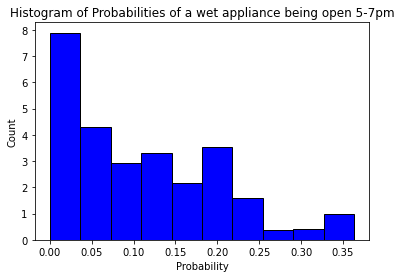

In [60]:
# Import the libraries
import matplotlib.pyplot as plt
import seaborn as sns

print(len(p))

# matplotlib histogram
plt.hist(prob_hist, color = 'blue', edgecolor = 'black',density=True)



# Add labels
plt.title('Histogram of Probabilities of a wet appliance being open 5-7pm')
plt.xlabel('Probability')
plt.ylabel('Count')

In [65]:
len(messages)

171

In [53]:
len(prob_hist)

3420

In [61]:
# seaborn histogram
sns.distplot(prob_hist, norm_hist=True)

[0.003066572379334206,
 0.19943697796164195,
 0.10136592713916595,
 8.244406466534596e-07,
 0.15116062691479232,
 0.019492864568149616,
 0.19474008073688498,
 0.011901048548417312,
 0.10597139338151296,
 0.3452105410059272,
 0.028429521012794536,
 0.24063604405727235,
 0.0970708927780213,
 0.015304414375754126,
 0.22805615167266657,
 0.018541429945412313,
 0.13923345972456727,
 0.022106658661908214,
 0.07217642530118956,
 0.11439875978182064,
 0.0012777384913892523,
 0.12984178252711065,
 0.14078600991550827,
 2.061101616633649e-06,
 0.19682373296196917,
 0.03384177876414864,
 0.14947155319717048,
 0.006524697669088439,
 0.19066822672810096,
 0.3595943135478408,
 0.011845633755331056,
 0.23673684889893692,
 0.1454045052214563,
 0.06376839323230885,
 0.19796540943807864,
 0.038627979052942324,
 0.08057491882208756,
 0.04605553887897544,
 0.07035210231003594,
 0.12617510270053744,
 0.0012777384913892523,
 0.19476267379066597,
 0.14958513553522754,
 2.404618552739257e-06,
 0.1574589863695

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

from scipy import interp
from sklearn.metrics import roc_auc_score

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(states, randprobs)
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [ ]:
d = { 'real': states, 'probs': randprobs }
roc_df = pd.DataFrame(d)
roc_df.to_csv('demo.csv')